In [ ]:
import pandas as pd

# Load data
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')


In [ ]:
data = pd.merge(customers, transactions, on='CustomerID')


In [ ]:
spending = data.groupby('CustomerID')['TotalValue'].sum().reset_index()
spending.columns = ['CustomerID', 'TotalSpending']
data = pd.merge(customers, spending, on='CustomerID')


In [ ]:
data['Tenure'] = (pd.to_datetime('2025-01-01') - pd.to_datetime(data['SignupDate'])).dt.days
transaction_stats = transactions.groupby('CustomerID').agg(
    TransactionCount=('TransactionID', 'count'),
    AvgTransactionValue=('TotalValue', 'mean')
).reset_index()
data = pd.merge(data, transaction_stats, on='CustomerID')


In [ ]:
from sklearn.preprocessing import StandardScaler

features = ['TotalSpending', 'Tenure', 'TransactionCount', 'AvgTransactionValue']
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])


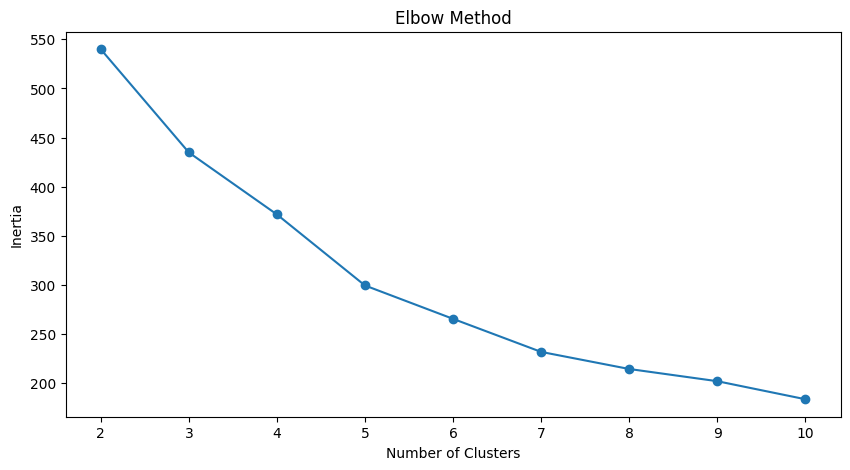

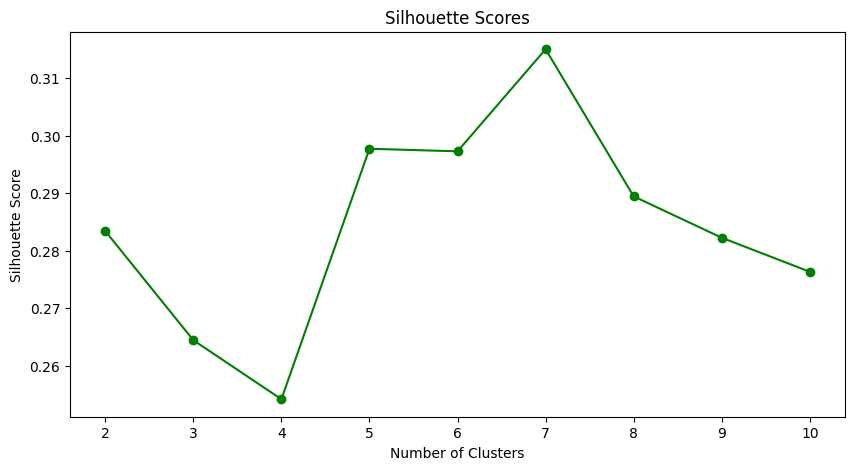

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

inertia = []
sil_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(data_scaled, kmeans.labels_))

# Elbow plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Silhouette score plot
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), sil_scores, marker='o', color='green')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


In [ ]:
optimal_clusters = 4  # Example, determined by the elbow method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

data['Cluster'] = clusters


In [ ]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(data_scaled, clusters)
print(f'Davies-Bouldin Index: {db_index}')


Davies-Bouldin Index: 1.1612210862676202


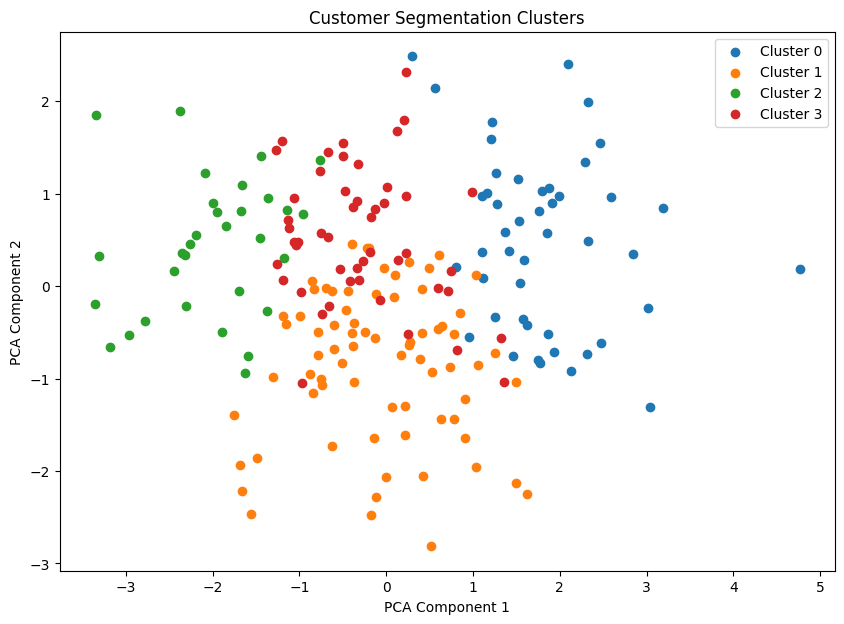

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(data_scaled)

# Scatter plot of clusters
plt.figure(figsize=(10, 7))
for cluster in range(optimal_clusters):
    cluster_points = pca_data[data['Cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
plt.title('Customer Segmentation Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


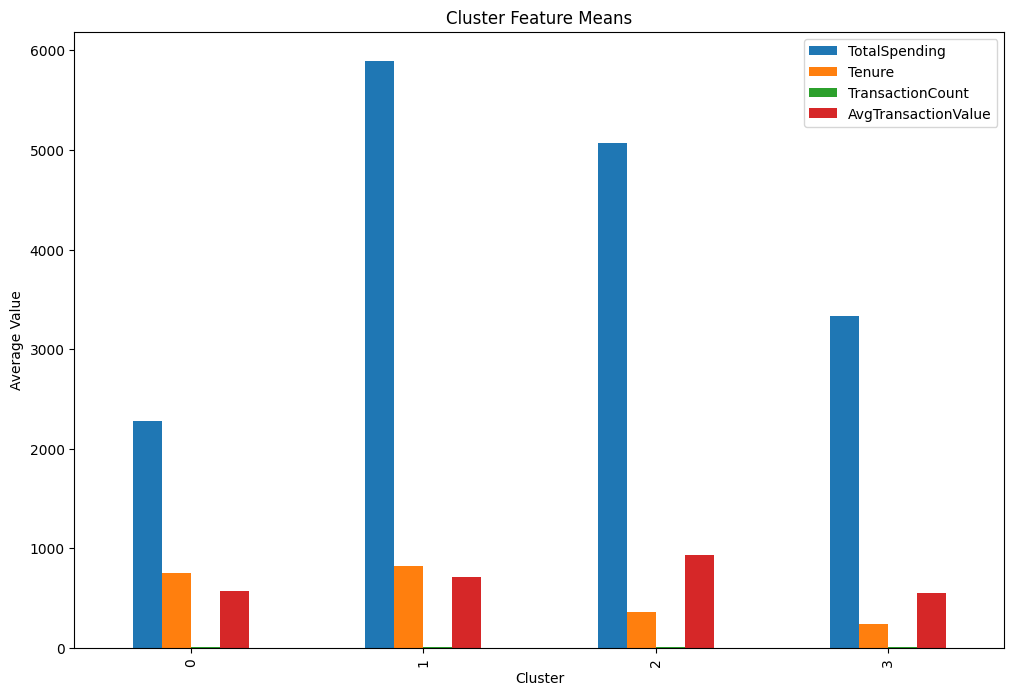

In [ ]:
import seaborn as sns

cluster_means = data.groupby('Cluster')[features].mean()
cluster_means.plot(kind='bar', figsize=(12, 8))
plt.title('Cluster Feature Means')
plt.ylabel('Average Value')
plt.xlabel('Cluster')
plt.show()
# Save Clustering Results
data.to_csv('Clustering_Results.csv', index=False)


CODE 2 USING DBSCAN,HIERARCHICAL CLUSTERINGS


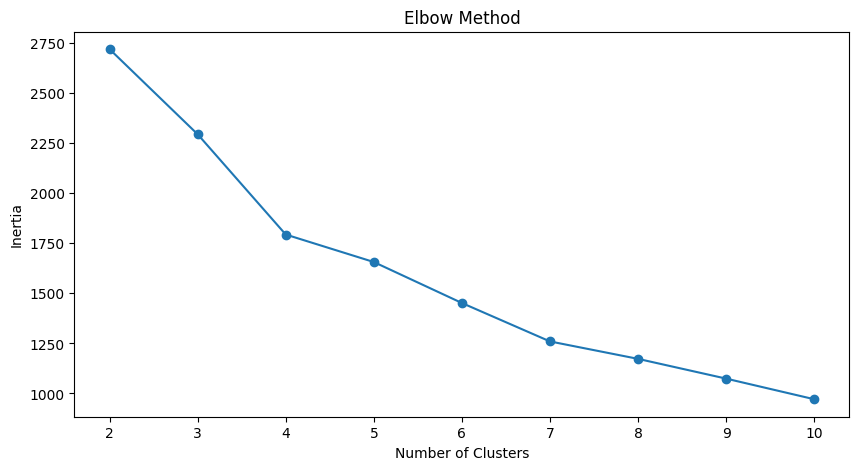

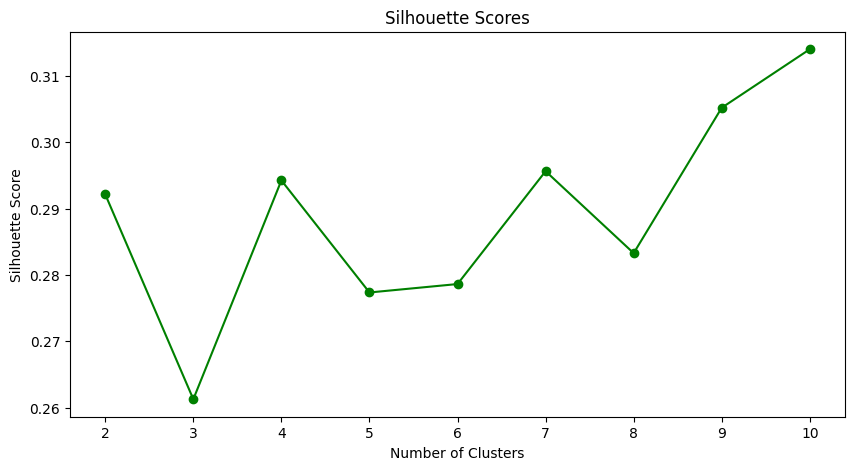

Optimal Clusters (DB Index): 10


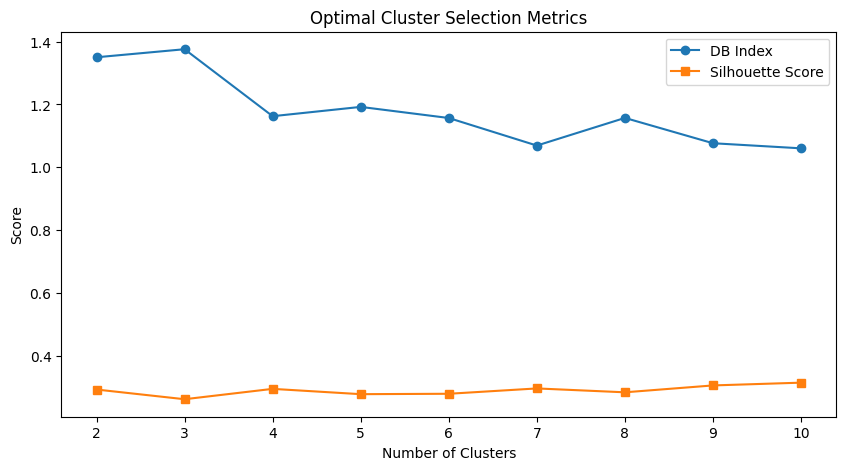

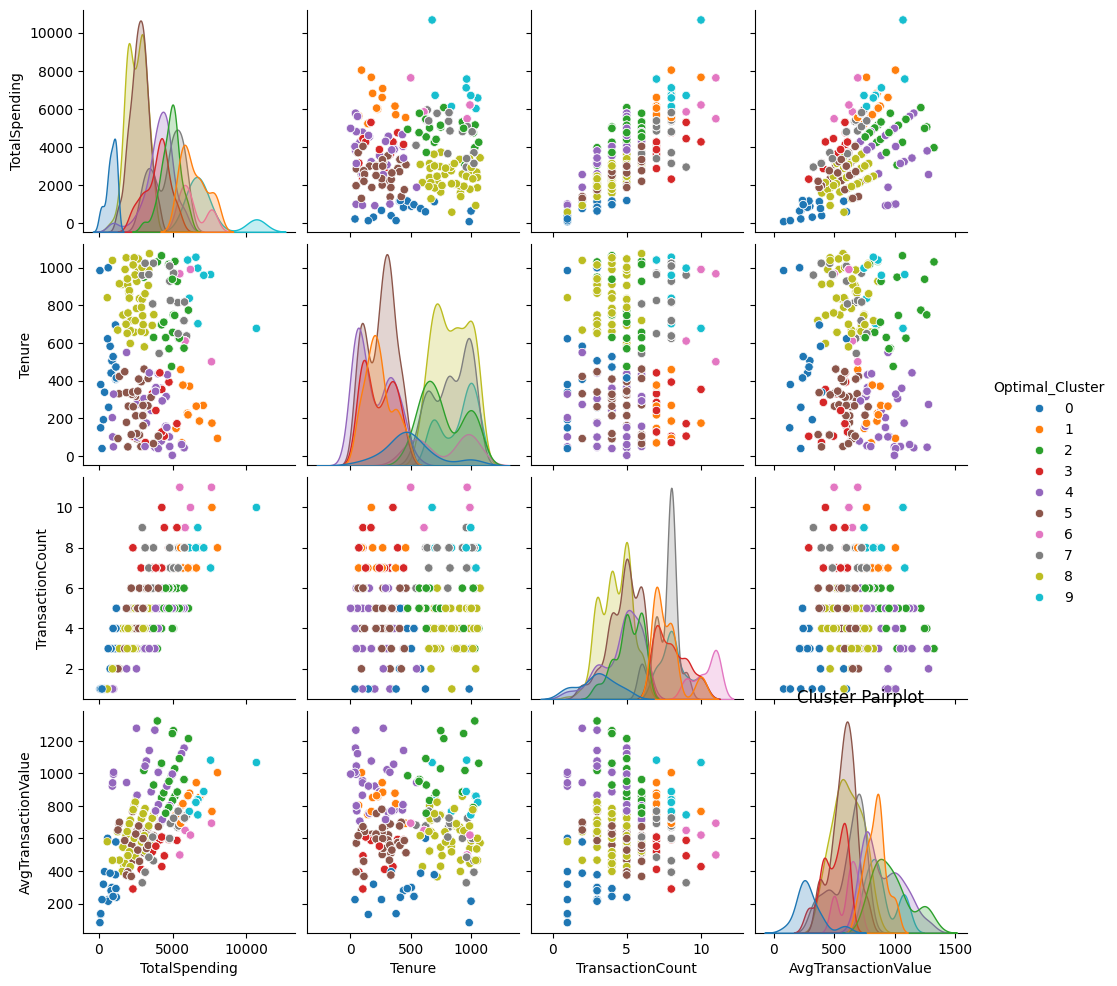

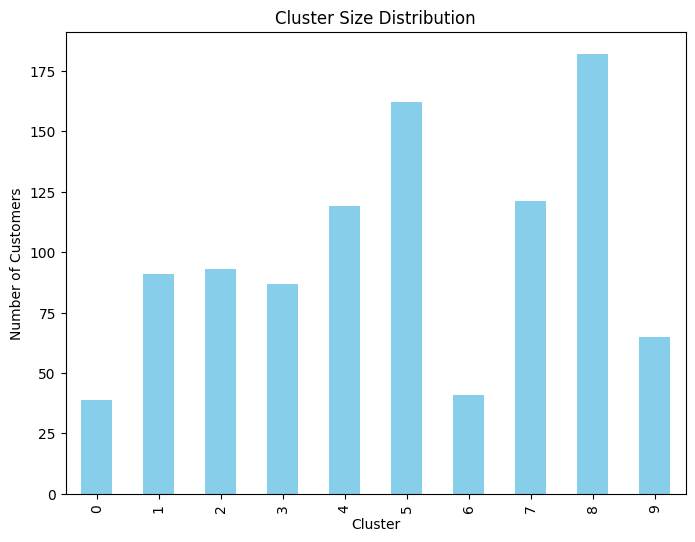

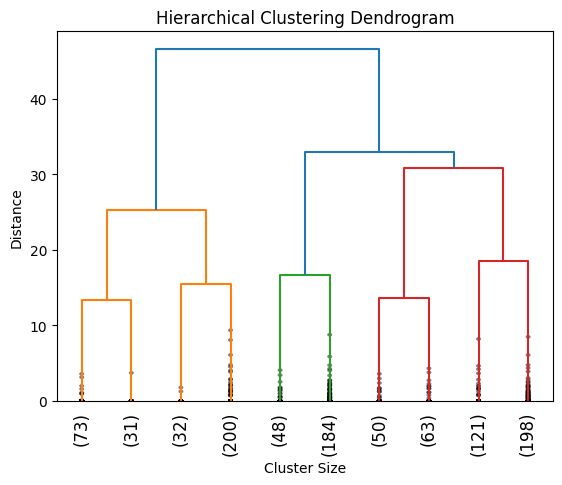

Davies-Bouldin Index (K-Means): 1.1627345473670503
Davies-Bouldin Index (DBSCAN): 0.4081211716068961


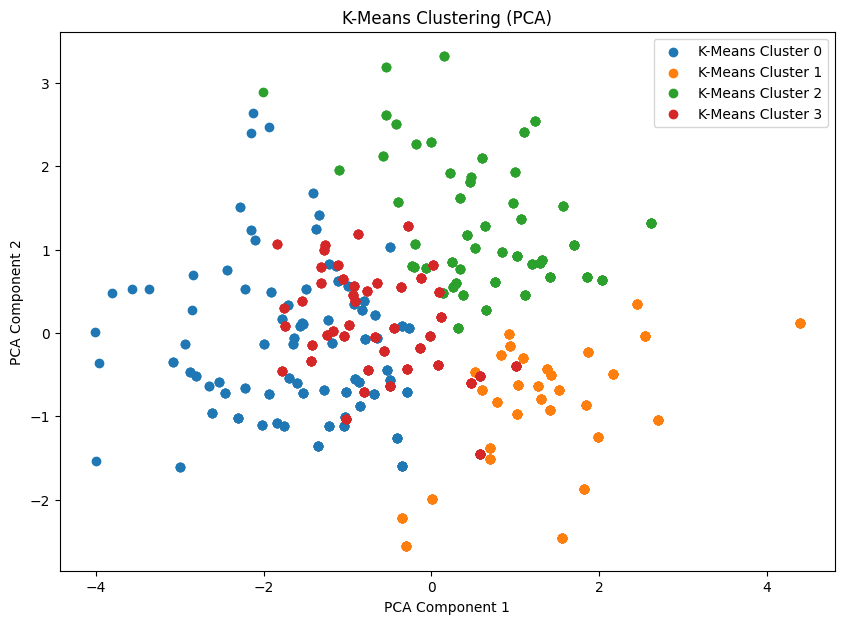

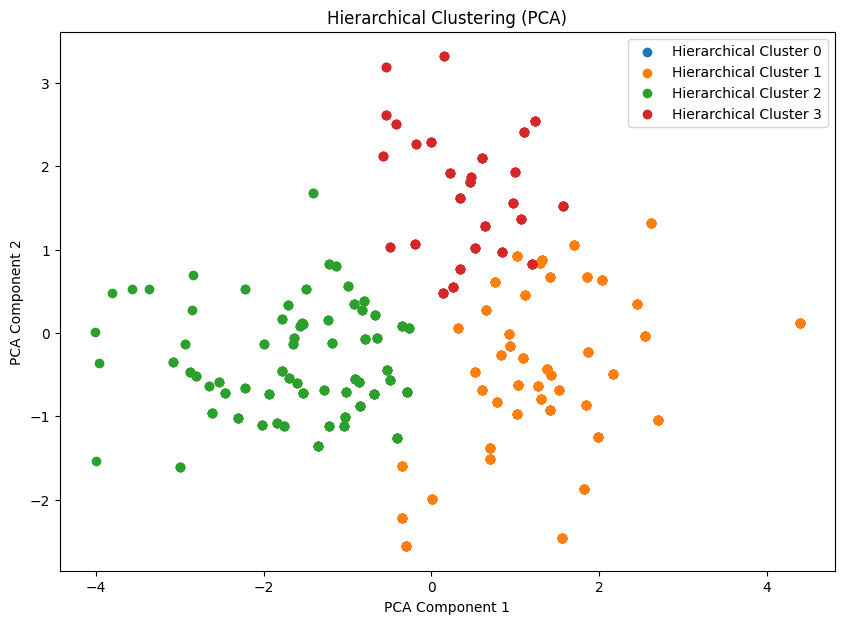

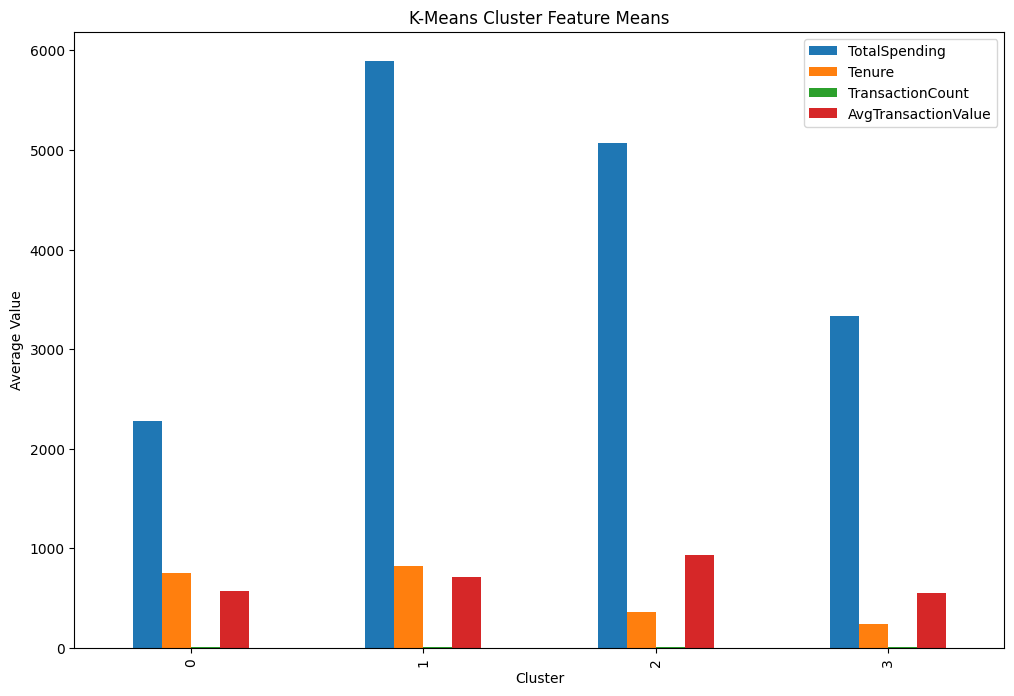

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Load data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge data
customer_data = pd.merge(customers, transactions, on='CustomerID')

# Feature Engineering
# Total Spending per Customer
spending = customer_data.groupby('CustomerID')['TotalValue'].sum().reset_index()
spending.columns = ['CustomerID', 'TotalSpending']

# Transaction Count and Average Transaction Value
transaction_stats = transactions.groupby('CustomerID').agg(
    TransactionCount=('TransactionID', 'count'),
    AvgTransactionValue=('TotalValue', 'mean')
).reset_index()

# Tenure (Days since Signup)
customer_data['SignupDate'] = pd.to_datetime(customer_data['SignupDate'])
current_date = pd.to_datetime('2025-01-01')  # Replace with the current date
customer_data['Tenure'] = (current_date - customer_data['SignupDate']).dt.days

# Merge all features into the data
data = pd.merge(customers, spending, on='CustomerID')
data = pd.merge(data, transaction_stats, on='CustomerID')
data = pd.merge(data, customer_data[['CustomerID', 'Tenure']], on='CustomerID')

# One-hot encode 'Region'
data = pd.get_dummies(data, columns=['Region'], drop_first=True)


features = ['TotalSpending', 'Tenure', 'TransactionCount', 'AvgTransactionValue']
data_scaled = StandardScaler().fit_transform(data[features])

# Handle Missing Data (only for numeric features)
# Select only numeric columns for filling missing values
numeric_data = data.select_dtypes(include=np.number)
numeric_data.fillna(numeric_data.mean(), inplace=True)

# Update original DataFrame with filled values
for col in numeric_data.columns:
    data[col] = numeric_data[col]

# ... (rest of your code) ...
inertia = []
sil_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(data_scaled, kmeans.labels_))

# Plot Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), sil_scores, marker='o', color='green')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Automate Optimal Cluster Selection (Using Davies-Bouldin Index)
db_indices = []
sil_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    db_indices.append(davies_bouldin_score(data_scaled, kmeans.labels_))
    sil_scores.append(silhouette_score(data_scaled, kmeans.labels_))

# Optimal Number of Clusters Based on Minimum Davies-Bouldin Index
optimal_clusters_db = np.argmin(db_indices) + 2  # Adding 2 because range starts from 2
print(f"Optimal Clusters (DB Index): {optimal_clusters_db}")

# Cluster Interpretation (Adding Descriptive Labels)
kmeans_optimal = KMeans(n_clusters=optimal_clusters_db, random_state=42)
data['Optimal_Cluster'] = kmeans_optimal.fit_predict(data_scaled)

# Map clusters to descriptive labels (manually defined or based on averages)
cluster_means = data.groupby('Optimal_Cluster')[features].mean()
data['Cluster_Description'] = data['Optimal_Cluster'].map({
    0: 'High Spenders',
    1: 'Moderate Spenders',
    2: 'Occasional Buyers',
    3: 'New Customers'
    # Adjust based on cluster_means insights
})

# Visualizations: Optimal Cluster Metrics
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), db_indices, marker='o', label='DB Index')
plt.plot(range(2, 11), sil_scores, marker='s', label='Silhouette Score')
plt.title('Optimal Cluster Selection Metrics')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

# Additional Visualizations
# Pairplot for Clusters
sns.pairplot(data, vars=features, hue='Optimal_Cluster', palette='tab10')
plt.title('Cluster Pairplot')
plt.show()

# Cluster Size Distribution
cluster_sizes = data['Optimal_Cluster'].value_counts().sort_index()
cluster_sizes.plot(kind='bar', figsize=(8, 6), color='skyblue')
plt.title('Cluster Size Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.show()

# Perform K-Means Clustering (Optimal Number of Clusters)
optimal_clusters = 4  # Example based on the Elbow Method
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Perform DBSCAN Clustering (Density-Based)
dbscan = DBSCAN(eps=1.5, min_samples=5)
data['DBSCAN_Cluster'] = dbscan.fit_predict(data_scaled)

# Perform Hierarchical Clustering
linked = linkage(data_scaled, method='ward')
dendrogram(linked, truncate_mode='lastp', p=10, leaf_rotation=90., leaf_font_size=12., show_contracted=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.show()
data['Hierarchical_Cluster'] = fcluster(linked, t=optimal_clusters, criterion='maxclust')

# Evaluate K-Means Clustering
db_index_kmeans = davies_bouldin_score(data_scaled, data['Cluster'])
print(f'Davies-Bouldin Index (K-Means): {db_index_kmeans}')

# Evaluate DBSCAN Clustering (if applicable)
dbscan_clusters = data['DBSCAN_Cluster'].nunique()
if dbscan_clusters > 1:
    db_index_dbscan = davies_bouldin_score(data_scaled, data['DBSCAN_Cluster'])
    print(f'Davies-Bouldin Index (DBSCAN): {db_index_dbscan}')
else:
    print("DBSCAN resulted in a single cluster or noise only.")

# Visualize Clusters using PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data_scaled)

data['PCA1'] = pca_data[:, 0]
data['PCA2'] = pca_data[:, 1]

plt.figure(figsize=(10, 7))
for cluster in range(optimal_clusters):
    cluster_points = data[data['Cluster'] == cluster]
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'], label=f'K-Means Cluster {cluster}')
plt.title('K-Means Clustering (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

plt.figure(figsize=(10, 7))
for cluster in range(data['Hierarchical_Cluster'].nunique()):
    cluster_points = data[data['Hierarchical_Cluster'] == cluster]
    plt.scatter(cluster_points['PCA1'], cluster_points['PCA2'], label=f'Hierarchical Cluster {cluster}')
plt.title('Hierarchical Clustering (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

# Cluster Characteristics
cluster_means = data.groupby('Cluster')[features].mean()
cluster_means.plot(kind='bar', figsize=(12, 8))
plt.title('K-Means Cluster Feature Means')
plt.ylabel('Average Value')
plt.xlabel('Cluster')
plt.show()

# Save Clustering Results
data.to_csv('Clustering_Results.csv', index=False)
